In [1]:
import argparse
import json
import os
import time
import copy
import warnings
import numpy as np
import sys


from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

# Training settings
# explore this:
# from eval_gcn import ensemble_performance
# !!!

from deeplim.training import evaluate, train_epoch, train_epoch_LIM, get_dataloaders, evaluate_LIM, evaluate_LIM_prob, evaluate_LIM_evloss_3out, evaluate_LIM_evloss_raw

from deeplim.GCN.GCN_model import GCN
from deeplim.DLIM.deeplim_model import nlim
from utilities.utils import set_gpu, set_seed
from utilities.model_logging import update_tqdm, save_model
from utilities.optimization import get_optimizer, get_loss
import matplotlib.pyplot as plt
import torch

from scipy import stats
import scipy

/glade/work/wchapman/miniconda3/envs/gputorch/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
warnings.filterwarnings("ignore")  # or use: "once"

## EVIDENTIAL NETWORKS ONLY

seed 42
Train set: 36132 Validation set 600 Test set 408
[GraphConvolution (6 -> 250), GraphConvolution (250 -> 250), GraphConvolution (250 -> 250), GraphConvolution (250 -> 1)]
0.9114444786808668
rmse:  0.4092243


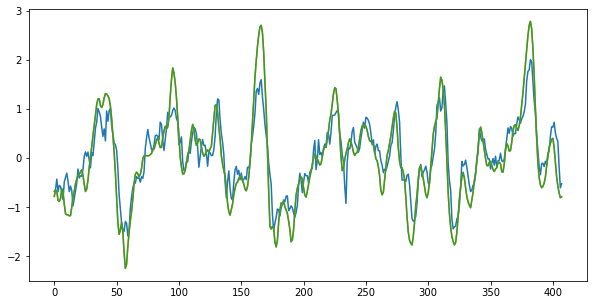

===========+++++=============
final ensemble corr for horizon:  3   0.9149686233511634
final ensemble rmse for horizon:  3   0.8361775169619443
===========+++++=============


In [11]:
#load config files
config_files = ['config_bias_evloss']
ID = str(time.strftime('%Hh%Mm%Ss_on_%b_%d_%Y'))
for i, config_file in enumerate(config_files):
    with open(f'configs/DLIM_{config_file}.json', 'r') as f:
        config = json.load(f)
    params, net_params = config['params'], config['net_params']
#load model
for horizon in [3]:
    plt.figure(figsize=(10,5))    
    ts=np.zeros([8,408])
    for nummmer,seed in enumerate([42]):
        print('seed',seed)
        params['horizon']=horizon
        params['epochs']=30
        
        if horizon in [1,2]:
            params['lat_min']=-10
            params['lat_max']=10
        elif horizon in [3,4]:
            params['lat_min']=-15
            params['lat_max']=15
        elif horizon in [5,6]:
            params['lat_min']=-30
            params['lat_max']=30
        elif horizon in [7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]:
            params['lat_min']=-55
            params['lat_max']=60

        (adj, static_feats, _), (trainloader,valloader,testloader) = get_dataloaders(params, net_params)
        static_feats = static_feats[:,2:]
        static_feats = np.concatenate([static_feats[:,:int(static_feats.shape[1]/2)],static_feats[:,int(static_feats.shape[1]/2):]])
        config['net_params']=100
        outsize=1
        # net_params['L']=2
        # params['horizon']=10
        model = nlim(net_params, params,static_feat=static_feats, adj=adj,outsize=outsize,device='cpu')
        outbase_dir = 'out/'+str(params['horizon'])+'lead/'
        out_mod_dir = outbase_dir+'/'+config_file+'/'
        mod_name =out_mod_dir+'/LIM'+'_numeofs_' + f'{net_params["num_eofs"]:03}'+'_seed_' + f'{seed:03}'+'_optimizer_'+params["optimizer"]+'_loss_'+params["loss"]+'_epochs_'+f'{params["epochs"]:03}'+'.pth'
        bb = torch.load(mod_name,map_location=torch.device('cpu'))
        model.load_state_dict(bb['model_state_dict'])
        
        
        if params['loss'] != 'evloss':
            print('..This is only for EVLOSS evaluation...')
            raise ValueError('...This is only for EVLOSS evaluation...')
        
        
        _, val_stats,truer,preder,unc_a,unc_e = evaluate_LIM_evloss_3out(testloader,model, device='cpu',return_preds=True)        
        corr_ens = np.corrcoef(preder[0:408],truer[0:408])[0,1]
        if corr_ens<=0:
            corr_ens = corr_ens*-1
            preder[0:] = preder[0:]*-1
        
        print(corr_ens)
        plt.plot(preder[0:])
        plt.plot(truer[0:])
        print('rmse: ', np.sqrt(np.mean((preder-truer)**2)))
        ts[nummmer,:]=preder
    plt.plot(truer[0:])
    plt.show()
    print('===========+++++=============')
    print('final ensemble corr for horizon: ',params['horizon'],' ',np.corrcoef(np.mean(ts,axis=0)[0:400],truer[0:400])[0,1])
    print('final ensemble rmse for horizon: ',params['horizon'],' ', np.sqrt(np.mean((np.mean(ts,axis=0)-truer)**2)))
    print('===========+++++=============')


seed 42
Train set: 36132 Validation set 600 Test set 408
[GraphConvolution (6 -> 250), GraphConvolution (250 -> 250), GraphConvolution (250 -> 250), GraphConvolution (250 -> 1)]
0.9114444786808668
rmse:  0.4092243


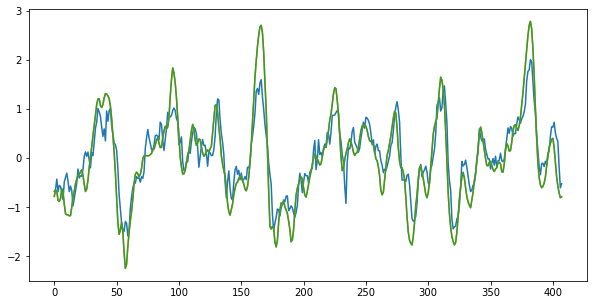

===========+++++=============
final ensemble corr for horizon:  3   0.9149686233511634
final ensemble rmse for horizon:  3   0.8361775169619443
===========+++++=============


In [8]:
#load config files
config_files = ['config_bias_evloss']
ID = str(time.strftime('%Hh%Mm%Ss_on_%b_%d_%Y'))
for i, config_file in enumerate(config_files):
    with open(f'configs/DLIM_{config_file}.json', 'r') as f:
        config = json.load(f)
    params, net_params = config['params'], config['net_params']
#load model
for horizon in [3]:
    plt.figure(figsize=(10,5))    
    ts=np.zeros([8,408])
    for nummmer,seed in enumerate([42]):
        print('seed',seed)
        params['horizon']=horizon
        params['epochs']=30
        
        if horizon in [1,2]:
            params['lat_min']=-10
            params['lat_max']=10
        elif horizon in [3,4]:
            params['lat_min']=-15
            params['lat_max']=15
        elif horizon in [5,6]:
            params['lat_min']=-30
            params['lat_max']=30
        elif horizon in [7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]:
            params['lat_min']=-55
            params['lat_max']=60

        (adj, static_feats, _), (trainloader,valloader,testloader) = get_dataloaders(params, net_params)
        static_feats = static_feats[:,2:]
        static_feats = np.concatenate([static_feats[:,:int(static_feats.shape[1]/2)],static_feats[:,int(static_feats.shape[1]/2):]])
        config['net_params']=100
        outsize=1
        # net_params['L']=2
        # params['horizon']=10
        model = nlim(net_params, params,static_feat=static_feats, adj=adj,outsize=outsize,device='cpu')
        outbase_dir = 'out/'+str(params['horizon'])+'lead/'
        out_mod_dir = outbase_dir+'/'+config_file+'/'
        mod_name =out_mod_dir+'/LIM'+'_numeofs_' + f'{net_params["num_eofs"]:03}'+'_seed_' + f'{seed:03}'+'_optimizer_'+params["optimizer"]+'_loss_'+params["loss"]+'_epochs_'+f'{params["epochs"]:03}'+'.pth'
        bb = torch.load(mod_name,map_location=torch.device('cpu'))
        model.load_state_dict(bb['model_state_dict'])
        
        
        if params['loss'] != 'evloss':
            print('..This is only for EVLOSS evaluation...')
            raise ValueError('...This is only for EVLOSS evaluation...')
        
        
        _, val_stats,truer,gamma,nu,alpha,beta = evaluate_LIM_evloss_raw(testloader,model, device='cpu',return_preds=True)        
        corr_ens = np.corrcoef(gamma[0:408],truer[0:408])[0,1]
        if corr_ens<=0:
            corr_ens = corr_ens*-1
            gamma[0:] = gamma[0:]*-1
        
        print(corr_ens)
        plt.plot(gamma[0:])
        plt.plot(truer[0:])
        print('rmse: ', np.sqrt(np.mean((gamma-truer)**2)))
        ts[nummmer,:]=gamma
    plt.plot(truer[0:])
    plt.show()
    print('===========+++++=============')
    print('final ensemble corr for horizon: ',params['horizon'],' ',np.corrcoef(np.mean(ts,axis=0)[0:400],truer[0:400])[0,1])
    print('final ensemble rmse for horizon: ',params['horizon'],' ', np.sqrt(np.mean((np.mean(ts,axis=0)-truer)**2)))
    print('===========+++++=============')


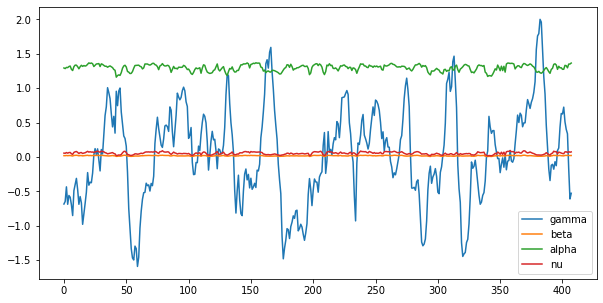

In [20]:
gamma,nu,alpha,beta
plt.figure(figsize=(10,5))
plt.plot(gamma,label='gamma')
plt.plot(np.sqrt(beta),label='beta')
plt.plot(np.sqrt(alpha),label='alpha')
plt.plot(np.sqrt(nu),label='nu')
plt.legend()
plt.show()

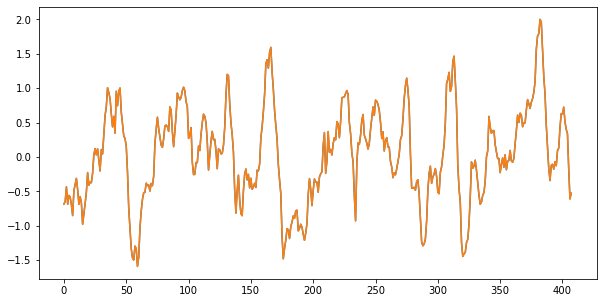

In [6]:
plt.figure(figsize=(10,5))   
plt.plot(preder[0:])
plt.plot(preder[0:]+unc_a[0:])
plt.show()

seed 10
Train set: 36132 Validation set 600 Test set 408
outputdim: 1
[GraphConvolution (6 -> 250), GraphConvolution (250 -> 250), GraphConvolution (250 -> 250), GraphConvolution (250 -> 1)]
0.904037210474864
rmse:  0.4071481


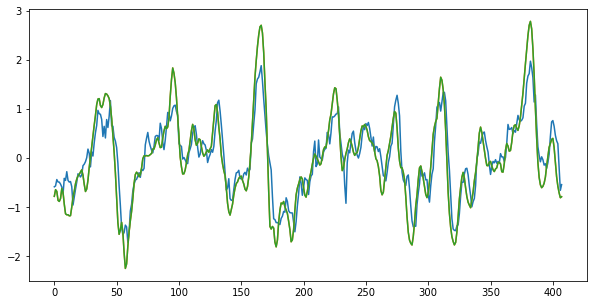

===========+++++=============
final ensemble corr for horizon:  3   0.906997741649089
final ensemble rmse for horizon:  3   0.8326680934479782
===========+++++=============


In [10]:
#load config files
config_files = ['config_bias_crps']
ID = str(time.strftime('%Hh%Mm%Ss_on_%b_%d_%Y'))
for i, config_file in enumerate(config_files):
    with open(f'configs/DLIM_{config_file}.json', 'r') as f:
        config = json.load(f)
    params, net_params = config['params'], config['net_params']
#load model
for horizon in [3]:
    plt.figure(figsize=(10,5))    
    ts=np.zeros([8,408])
    for nummmer,seed in enumerate([10]):
        print('seed',seed)
        params['horizon']=horizon
        params['epochs']=30
        
        
        if horizon in [1,2]:
            params['lat_min']=-10
            params['lat_max']=10
        elif horizon in [3,4]:
            params['lat_min']=-15
            params['lat_max']=15
        elif horizon in [5,6]:
            params['lat_min']=-30
            params['lat_max']=30
        elif horizon in [7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]:
            params['lat_min']=-55
            params['lat_max']=60

        (adj, static_feats, _), (trainloader,valloader,testloader) = get_dataloaders(params, net_params)
        static_feats = static_feats[:,2:]
        static_feats = np.concatenate([static_feats[:,:int(static_feats.shape[1]/2)],static_feats[:,int(static_feats.shape[1]/2):]])
        config['net_params']=100
        outsize=1
        # net_params['L']=2
        # params['horizon']=10
        model = nlim(net_params, params,static_feat=static_feats, adj=adj,outsize=outsize,device='cpu')
        outbase_dir = 'out/'+str(params['horizon'])+'lead/'
        out_mod_dir = outbase_dir+'/'+config_file+'/'
        mod_name =out_mod_dir+'/LIM'+'_numeofs_' + f'{net_params["num_eofs"]:03}'+'_seed_' + f'{seed:03}'+'_optimizer_'+params["optimizer"]+'_loss_'+params["loss"]+'_epochs_'+f'{params["epochs"]:03}'+'.pth'
        bb = torch.load(mod_name,map_location=torch.device('cpu'))
        model.load_state_dict(bb['model_state_dict'])
        _, val_stats,truer_c,preder_c,scales_c = evaluate_LIM_prob(testloader,model, device='cpu',return_preds=True)        
        corr_ens = np.corrcoef(preder[0:408],truer[0:408])[0,1]
        if corr_ens<=0:
            corr_ens = corr_ens*-1
            preder[0:] = preder[0:]*-1
        
        print(corr_ens)
        plt.plot(preder_c[0:])
        plt.plot(truer_c[0:])
        print('rmse: ', np.sqrt(np.mean((preder_c-truer_c)**2)))
        ts[nummmer,:]=preder_c
    plt.plot(truer_c[0:])
    plt.show()
    print('===========+++++=============')
    print('final ensemble corr for horizon: ',params['horizon'],' ',np.corrcoef(np.mean(ts,axis=0)[0:400],truer[0:400])[0,1])
    print('final ensemble rmse for horizon: ',params['horizon'],' ', np.sqrt(np.mean((np.mean(ts,axis=0)-truer)**2)))
    print('===========+++++=============')


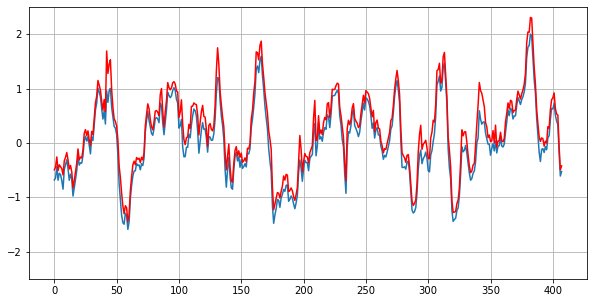

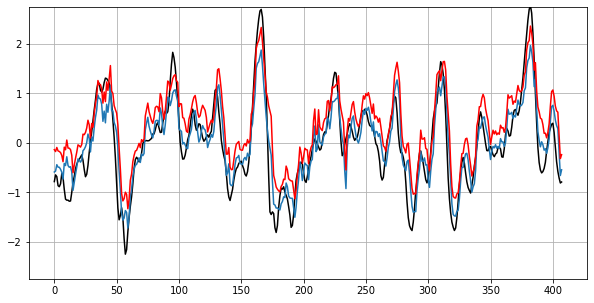

In [24]:
plt.figure(figsize=(10,5))   
plt.plot(preder[0:])
plt.plot(preder[0:]+unc_e[0:],color='r')
plt.ylim([-2.5,2.5])
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))   
plt.plot(truer_c[0:],color='k')
plt.plot(preder_c[0:])
plt.plot(preder_c[0:]+scales_c[0:],color='r')
plt.ylim([-2.75,2.75])
plt.grid(True)
plt.show()

In [2]:
warnings.filterwarnings("ignore")  # or use: "once"

seed 10
Train set: 36132 Validation set 600 Test set 408
outputdim: 1
[GraphConvolution (6 -> 250), GraphConvolution (250 -> 250), GraphConvolution (250 -> 250), GraphConvolution (250 -> 1)]
0.9761740632482857
rmse:  0.23740132
seed 11
Train set: 36132 Validation set 600 Test set 408
outputdim: 1
[GraphConvolution (6 -> 250), GraphConvolution (250 -> 250), GraphConvolution (250 -> 250), GraphConvolution (250 -> 1)]
0.9744658970491604
rmse:  0.24549757
seed 12
Train set: 36132 Validation set 600 Test set 408
outputdim: 1
[GraphConvolution (6 -> 250), GraphConvolution (250 -> 250), GraphConvolution (250 -> 250), GraphConvolution (250 -> 1)]
0.9782274502882319
rmse:  0.22254391
seed 13
Train set: 36132 Validation set 600 Test set 408
outputdim: 1
[GraphConvolution (6 -> 250), GraphConvolution (250 -> 250), GraphConvolution (250 -> 250), GraphConvolution (250 -> 1)]
0.9740005559673487
rmse:  0.24891941
seed 14
Train set: 36132 Validation set 600 Test set 408
outputdim: 1
[GraphConvolution 

KeyboardInterrupt: 

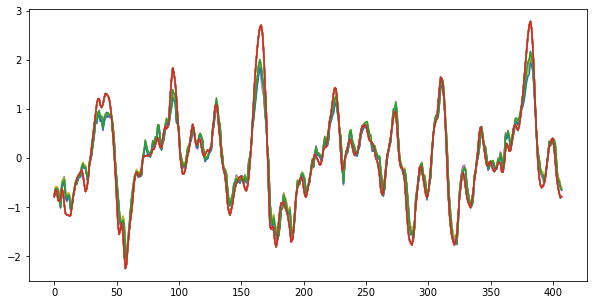

In [14]:
#load config files
config_files = ['config_bias_crps']
ID = str(time.strftime('%Hh%Mm%Ss_on_%b_%d_%Y'))
for i, config_file in enumerate(config_files):
    with open(f'configs/DLIM_{config_file}.json', 'r') as f:
        config = json.load(f)
    params, net_params = config['params'], config['net_params']
#load model
for horizon in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]:
    plt.figure(figsize=(10,5))    
    ts=np.zeros([8,408])
    for nummmer,seed in enumerate([10,11,12,13,14,15,16,17]):
        print('seed',seed)
        params['horizon']=horizon
        params['epochs']=30
        
        
        if horizon in [1,2]:
            params['lat_min']=-10
            params['lat_max']=10
        elif horizon in [3,4]:
            params['lat_min']=-15
            params['lat_max']=15
        elif horizon in [5,6]:
            params['lat_min']=-30
            params['lat_max']=30
        elif horizon in [7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]:
            params['lat_min']=-55
            params['lat_max']=60

        (adj, static_feats, _), (trainloader,valloader,testloader) = get_dataloaders(params, net_params)
        static_feats = static_feats[:,2:]
        static_feats = np.concatenate([static_feats[:,:int(static_feats.shape[1]/2)],static_feats[:,int(static_feats.shape[1]/2):]])
        config['net_params']=100
        outsize=1
        # net_params['L']=2
        # params['horizon']=10
        model = nlim(net_params, params,static_feat=static_feats, adj=adj,outsize=outsize,device='cpu')
        outbase_dir = 'out/'+str(params['horizon'])+'lead/'
        out_mod_dir = outbase_dir+'/'+config_file+'/'
        mod_name =out_mod_dir+'/LIM'+'_numeofs_' + f'{net_params["num_eofs"]:03}'+'_seed_' + f'{seed:03}'+'_optimizer_'+params["optimizer"]+'_loss_'+params["loss"]+'_epochs_'+f'{params["epochs"]:03}'+'.pth'
        bb = torch.load(mod_name,map_location=torch.device('cpu'))
        model.load_state_dict(bb['model_state_dict'])
        _, val_stats,truer,preder = evaluate_LIM(testloader,model, device='cpu',return_preds=True)        
        corr_ens = np.corrcoef(preder[0:408],truer[0:408])[0,1]
        if corr_ens<=0:
            corr_ens = corr_ens*-1
            preder[0:] = preder[0:]*-1
        
        print(corr_ens)
        plt.plot(preder[0:])
        plt.plot(truer[0:])
        print('rmse: ', np.sqrt(np.mean((preder-truer)**2)))
        ts[nummmer,:]=preder
    plt.plot(truer[0:])
    plt.show()
    print('===========+++++=============')
    print('final ensemble corr for horizon: ',params['horizon'],' ',np.corrcoef(np.mean(ts,axis=0)[0:400],truer[0:400])[0,1])
    print('final ensemble rmse for horizon: ',params['horizon'],' ', np.sqrt(np.mean((np.mean(ts,axis=0)-truer)**2)))
    print('===========+++++=============')


In [59]:
mod_name
bb = torch.load('out/1lead//config_bias_expand//LIM_numeofs_100_seed_001_optimizer_adam_loss_MSE_epochs_030.pth',map_location=torch.device('cpu'))

In [18]:
cnn.sel(lev=ii)['nino34'].squeeze()[24:]-truer

<xarray.DataArray 'nino34' (time: 408)>
array([ 3.63024175e-01,  2.18535691e-01,  2.73633540e-01,  5.67070365e-01,
        6.60764933e-01,  6.93369150e-01,  2.58344412e-01,  3.65209520e-01,
        5.43759584e-01,  6.86340034e-01,  4.36065078e-01,  4.34392929e-01,
        5.33808112e-01,  5.99853635e-01,  5.00388682e-01,  3.83923769e-01,
        3.76197487e-01,  4.79574323e-01,  3.42626601e-01,  2.79166073e-01,
        1.12850711e-01, -1.16811216e-01, -3.33010912e-01, -4.56809402e-02,
        1.53597713e-01,  4.59605902e-01,  5.75086415e-01,  4.45895314e-01,
        1.39730737e-01,  1.17602870e-01, -1.14045747e-01, -3.75107646e-01,
       -5.56786537e-01, -9.16190386e-01, -1.10498250e+00, -1.23945689e+00,
       -1.18741560e+00, -1.08690584e+00, -1.06686878e+00, -1.04002714e+00,
       -1.23028505e+00, -1.23969412e+00, -1.20845270e+00, -1.27962720e+00,
       -1.25444067e+00, -1.23144555e+00, -9.99754071e-01, -5.95676780e-01,
       -1.16275117e-01,  1.32743344e-01,  7.50542521e-01,  1.26878524e+00,
        1.49874187e+00,  1.51769555e+00,  1.14267087e+00,  1.21240079e+00,
        1.55059481e+00,  1.85482836e+00,  1.58125472e+00,  1.00201416e+00,
        6.41284227e-01,  4.78621423e-01,  4.75212157e-01,  3.14628601e-01,
        1.46745086e-01,  7.39231408e-02,  7.96125978e-02, -1.95401907e-02,
       -1.29679620e-01, -4.37382698e-01, -5.36862135e-01, -5.19075871e-01,
       -3.90145481e-01, -3.53206754e-01, -3.25518519e-01, -1.20498538e-01,
       -6.21228889e-02,  1.78597629e-01,  2.81075597e-01,  2.19246775e-01,
...
        9.29581702e-01,  7.89448619e-01,  9.01099682e-01,  6.54586494e-01,
        4.22113806e-01,  3.99708748e-04,  1.85182989e-02, -1.48212135e-01,
       -2.33802304e-01, -3.37457061e-01, -3.23365718e-01, -1.55003548e-01,
       -1.03266716e-01,  1.38758808e-01,  4.00238514e-01,  4.97403473e-01,
        3.62188458e-01,  2.17023477e-01, -7.83671439e-03,  1.71378434e-01,
        1.79637492e-01,  3.79209578e-01,  4.65583205e-01,  5.22467256e-01,
        3.75077099e-01,  3.75051290e-01,  6.28373981e-01,  7.37198651e-01,
        6.08542085e-01,  1.85727119e-01, -1.30823478e-01, -3.74175847e-01,
       -3.17498267e-01, -1.20832443e-01, -1.20459192e-01, -2.68327147e-01,
       -5.54719508e-01, -4.97599661e-01, -4.03035641e-01, -2.91036576e-01,
       -3.86522740e-01, -5.41891992e-01, -8.09211493e-01, -1.05149138e+00,
       -1.36555612e+00, -1.52894402e+00, -1.74770844e+00, -2.02783370e+00,
       -2.22917080e+00, -2.52891827e+00, -2.44781733e+00, -2.31411886e+00,
       -2.00500703e+00, -1.75250876e+00, -1.23711467e+00, -6.20652974e-01,
        4.67962772e-03,  4.26951706e-01,  6.79699898e-01,  6.35668337e-01,
        4.47143465e-01,  3.42297971e-01,  2.09717184e-01,  1.22818865e-01,
       -1.78002521e-01, -3.68649811e-01, -7.13915467e-01, -6.73810184e-01,
       -6.94970012e-01, -3.83403540e-01, -1.70087427e-01,  1.24931931e-01,
        2.67653555e-01,  4.28075463e-01,  4.84798729e-01,  5.44503212e-01],
      dtype=float32)
Coordinates:
    lon      float64 0.0
    lat      float64 -90.0
    lev      float64 23.0
  * time     (time) datetime64[ns] 1984-01-01 1984-02-01 ... 2017-12-01

In [23]:
np.array(np.sqrt(np.mean((cnn.sel(lev=ii)['nino34'].squeeze()[24:]-truer)**2)))

array(0.88364977, dtype=float32)

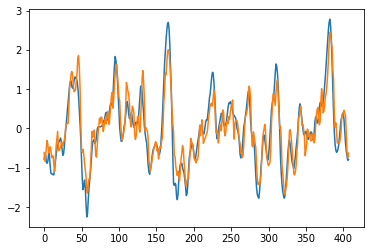

===========+++++=============
final ensemble corr for horizon:  1   0.9111951025128608
final ensemble rmse for horizon:  4   0.37927583
===========+++++=============


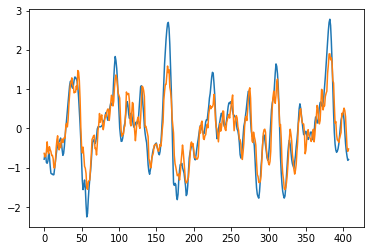

===========+++++=============
final ensemble corr for horizon:  2   0.9115790171788282
final ensemble rmse for horizon:  4   0.3914407
===========+++++=============


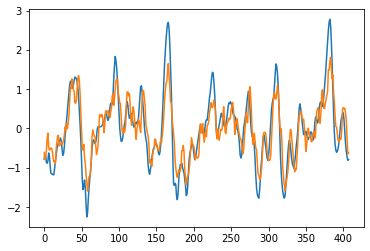

===========+++++=============
final ensemble corr for horizon:  3   0.8751210009363249
final ensemble rmse for horizon:  4   0.45848182
===========+++++=============


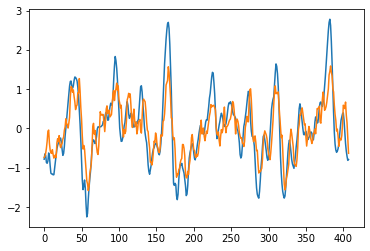

===========+++++=============
final ensemble corr for horizon:  4   0.8387270625677774
final ensemble rmse for horizon:  4   0.51601285
===========+++++=============


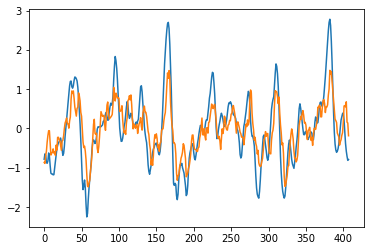

===========+++++=============
final ensemble corr for horizon:  5   0.8101616472384862
final ensemble rmse for horizon:  4   0.5609131
===========+++++=============


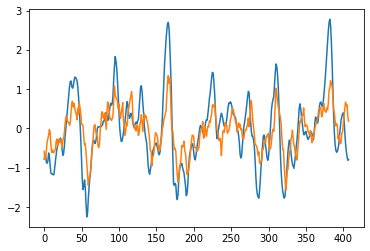

===========+++++=============
final ensemble corr for horizon:  6   0.7792350478414845
final ensemble rmse for horizon:  4   0.60554206
===========+++++=============


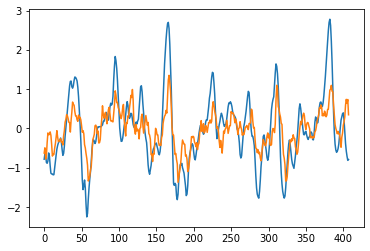

===========+++++=============
final ensemble corr for horizon:  7   0.743720957121789
final ensemble rmse for horizon:  4   0.6437947
===========+++++=============


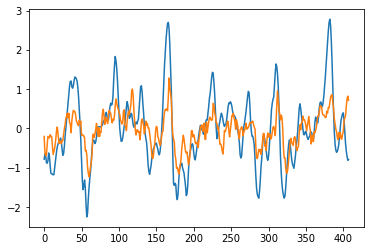

===========+++++=============
final ensemble corr for horizon:  8   0.7163249651310359
final ensemble rmse for horizon:  4   0.67603946
===========+++++=============


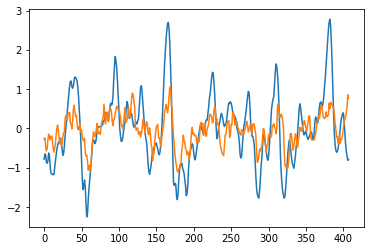

===========+++++=============
final ensemble corr for horizon:  9   0.6847578354571117
final ensemble rmse for horizon:  4   0.70055425
===========+++++=============


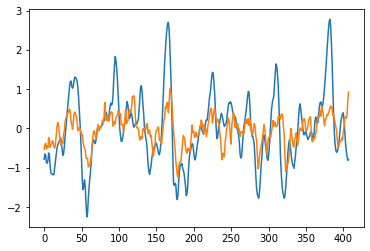

===========+++++=============
final ensemble corr for horizon:  10   0.6666630479292633
final ensemble rmse for horizon:  4   0.7150931
===========+++++=============


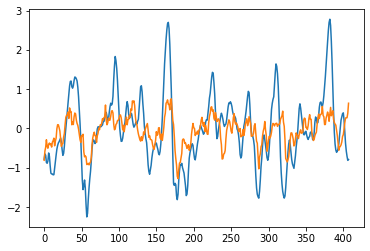

===========+++++=============
final ensemble corr for horizon:  11   0.6495732839486373
final ensemble rmse for horizon:  4   0.7304886
===========+++++=============


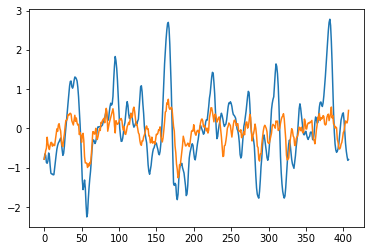

===========+++++=============
final ensemble corr for horizon:  12   0.6364957309575245
final ensemble rmse for horizon:  4   0.74520177
===========+++++=============


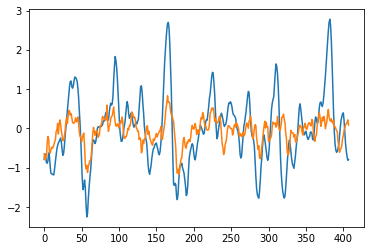

===========+++++=============
final ensemble corr for horizon:  13   0.6214145131960639
final ensemble rmse for horizon:  4   0.7534981
===========+++++=============


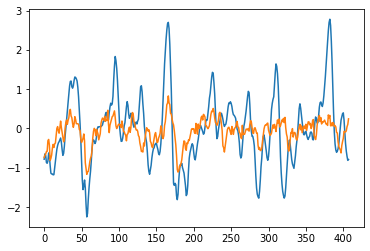

===========+++++=============
final ensemble corr for horizon:  14   0.594649694517718
final ensemble rmse for horizon:  4   0.76787263
===========+++++=============


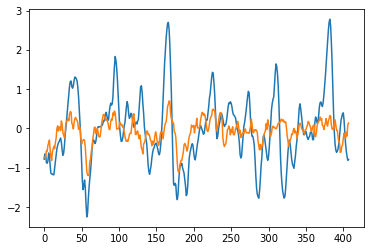

===========+++++=============
final ensemble corr for horizon:  15   0.571154912206139
final ensemble rmse for horizon:  4   0.7796249
===========+++++=============


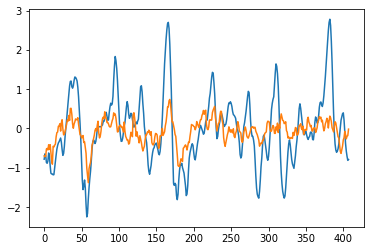

===========+++++=============
final ensemble corr for horizon:  16   0.54681745441103
final ensemble rmse for horizon:  4   0.7883217
===========+++++=============


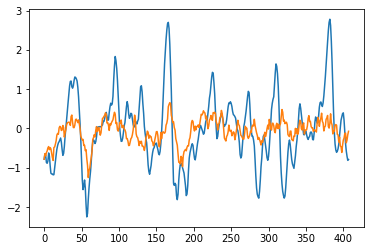

===========+++++=============
final ensemble corr for horizon:  17   0.5161287950098334
final ensemble rmse for horizon:  4   0.8011834
===========+++++=============


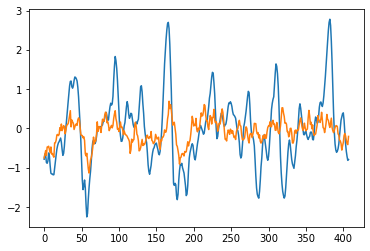

===========+++++=============
final ensemble corr for horizon:  18   0.46856469401111134
final ensemble rmse for horizon:  4   0.8182656
===========+++++=============


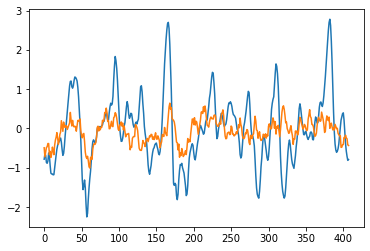

===========+++++=============
final ensemble corr for horizon:  19   0.42223624093323303
final ensemble rmse for horizon:  4   0.8330148
===========+++++=============


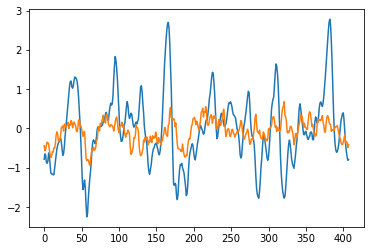

===========+++++=============
final ensemble corr for horizon:  20   0.35801735174020305
final ensemble rmse for horizon:  4   0.8539961
===========+++++=============


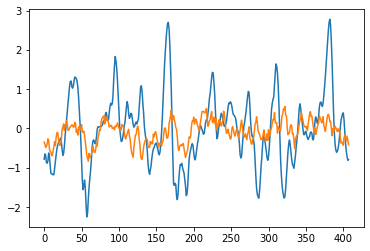

===========+++++=============
final ensemble corr for horizon:  21   0.3213435633314037
final ensemble rmse for horizon:  4   0.86596084
===========+++++=============


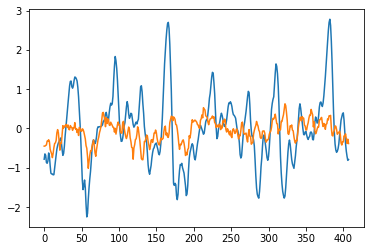

===========+++++=============
final ensemble corr for horizon:  22   0.2914935064196219
final ensemble rmse for horizon:  4   0.874271
===========+++++=============


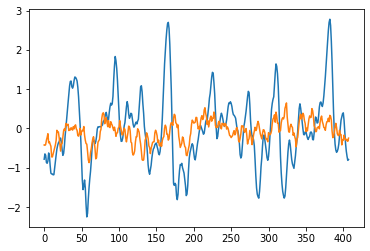

===========+++++=============
final ensemble corr for horizon:  23   0.2599781840838539
final ensemble rmse for horizon:  4   0.88364977
===========+++++=============


In [24]:

import xarray as xr
cnn = xr.open_dataset('/glade/work/wchapman/DeepLIM/Data/other_models/h19.hcst.nino34.1982_2016.nc')

for ii in range(1,24):
    plt.plot(truer)
    plt.plot(cnn.sel(lev=ii)['nino34'].squeeze()[24:])
    plt.show()
    
    print('===========+++++=============')
    print('final ensemble corr for horizon: ',ii,' ',np.corrcoef(cnn.sel(lev=ii)['nino34'].squeeze()[24:][0:408],truer[0:408])[0,1])
    print('final ensemble rmse for horizon: ',params['horizon'],' ', np.array(np.sqrt(np.mean((cnn.sel(lev=ii)['nino34'].squeeze()[24:]-truer)**2))))

    print('===========+++++=============')




Train set: 36132 Validation set 600 Test set 408
outputdim: 1
[GraphConvolution (6 -> 250), GraphConvolution (250 -> 1)]
0.9447293724304229


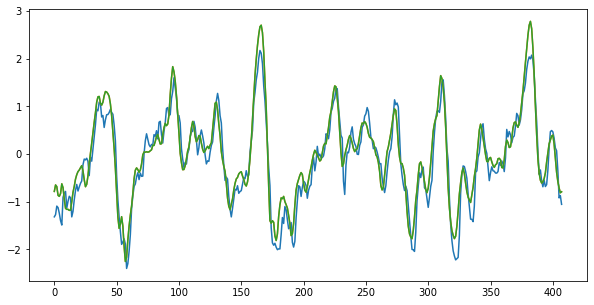

===========+++++=============
final ensemble corr for horizon:  2   0.9447293724304229
===========+++++=============


In [22]:
#load config files
config_files = ['config_bias_crps']
ID = str(time.strftime('%Hh%Mm%Ss_on_%b_%d_%Y'))
for i, config_file in enumerate(config_files):
    with open(f'configs/DLIM_{config_file}.json', 'r') as f:
        config = json.load(f)
    params, net_params = config['params'], config['net_params']
#load model
for horizon in [2]:
    plt.figure(figsize=(10,5))    
    ts=np.zeros([4,408])
    for seed in range(1,2):
        params['horizon']=horizon
        params['epochs']=2
        (adj, static_feats, _), (trainloader,valloader,testloader) = get_dataloaders(params, net_params)
        static_feats = static_feats[:,2:]
        static_feats = np.concatenate([static_feats[:,:int(static_feats.shape[1]/2)],static_feats[:,int(static_feats.shape[1]/2):]])
        outsize=1
        model = nlim(net_params, params,static_feat=static_feats, adj=adj,outsize=outsize,device='cpu')
        outbase_dir = 'out/'+str(params['horizon'])+'lead/'
        out_mod_dir = outbase_dir+'/'+config_file+'/'
        mod_name =out_mod_dir+'/LIM'+'_numeofs_' + f'{net_params["num_eofs"]:03}'+'_seed_' + f'{seed:03}'+'_optimizer_'+params["optimizer"]+'_loss_'+params["loss"]+'_epochs_'+f'{params["epochs"]:03}'+'.pth'
        bb = torch.load(mod_name,map_location=torch.device('cpu'))
        model.load_state_dict(bb['model_state_dict'])
        _, val_stats,truer,preder,scales = evaluate_LIM_prob(testloader,model, device='cpu',return_preds=True)
        plt.plot(preder[0:])
        plt.plot(truer[0:])
        print(np.corrcoef(preder[0:400],truer[0:400])[0,1])
        ts[seed-1,:]=preder
    plt.plot(truer[0:])
    plt.show()
    print('===========+++++=============')
    print('final ensemble corr for horizon: ',params['horizon'],' ',np.corrcoef(np.mean(ts,axis=0)[0:400],truer[0:400])[0,1])
    print('===========+++++=============')

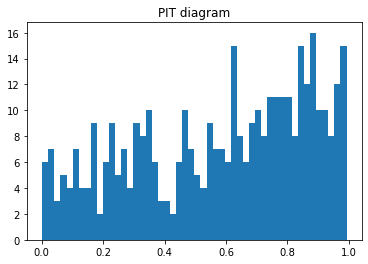

In [27]:
preder,scales
pp = stats.norm.cdf(x=truer[10:400],loc=preder[10:400],scale=scales[10:400])
plt.hist(pp,50)
plt.title('PIT diagram')
plt.show()